# 1-IMPORT LIBRARIES

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)
from sklearn.utils.class_weight import compute_sample_weight
from imblearn.over_sampling import SMOTE

# Visualization settings
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

print("✅ Libraries imported successfully!")


✅ Libraries imported successfully!


In [20]:
print("\n" + "="*80)
print("LOADING CLEANED DATA")
print("="*80)

# Load cleaned dataset
df = pd.read_csv('02_cleaned_data.csv')

print(f"✅ Data loaded: {df.shape[0]:,} samples, {df.shape[1]} features")

# Get feature columns (exclude targets)
final_features = [col for col in df.columns if col not in ['is_attack', 'label2']]

print(f"✅ Features: {len(final_features)}")
print(f"✅ Columns in dataset: {df.columns.tolist()}")


LOADING CLEANED DATA
✅ Data loaded: 227,191 samples, 41 features
✅ Features: 39
✅ Columns in dataset: ['network_time-delta_min', 'network_packets_all_count', 'network_packet-size_min', 'network_ports_all_count', 'network_ports_dst_count', 'network_packets_src_count', 'network_time-delta_avg', 'network_interval-packets', 'network_tcp-flags-ack_count', 'network_time-delta_max', 'network_time-delta_std_deviation', 'network_tcp-flags-syn_count', 'network_window-size_min', 'network_ttl_avg', 'network_window-size_std_deviation', 'network_mss_avg', 'network_ip-length_avg', 'network_protocols_dst_count', 'network_ip-length_min', 'network_ip-length_max', 'network_ttl_max', 'network_tcp-flags_std_deviation', 'network_ttl_min', 'network_window-size_avg', 'network_window-size_max', 'network_tcp-flags_avg', 'network_ips_all_count', 'network_ip-length_std_deviation', 'network_ttl_std_deviation', 'network_ip-flags_std_deviation', 'network_header-length_avg', 'network_payload-length_std_deviation', '

## 2- Encoding labels

In [16]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(df['label2'])

print("\n" + "="*60)
print("Label Encoding Mapping:")
print("="*60)
for i, label in enumerate(le.classes_):
    count = sum(df['label2'] == label)
    print(f"  {i}: {label:15s} → {count:,} samples")



Label Encoding Mapping:
  0: benign          → 136,800 samples
  1: bruteforce      → 1,868 samples
  2: ddos            → 18,056 samples
  3: dos             → 18,420 samples
  4: malware         → 7,541 samples
  5: mitm            → 8,062 samples
  6: recon           → 33,648 samples
  7: web             → 2,796 samples


## 3- Train / Test split

In [6]:
X = df.drop(columns=['label2'])     # all columns except the labe
print(X.shape)
print(y_encoded.shape)


(227191, 40)
(227191,)


In [7]:
from sklearn.model_selection import train_test_split
X = df[final_features]
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_encoded  # Keep class balance
)

print("\n" + "="*60)
print("📂 Train/Test Split:")
print("="*60)
print(f"  Train: {X_train.shape[0]:,} samples")
print(f"  Test:  {X_test.shape[0]:,} samples")


📂 Train/Test Split:
  Train: 181,752 samples
  Test:  45,439 samples


In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Features scaled!")

✅ Features scaled!


## Model 1 : Train with XGboost

### 1.1 Training of model

In [9]:
print("\n" + "="*60)
print("🤖 TRAINING MULTI-CLASS XGBOOST")
print("="*60)

xgb_multi = XGBClassifier(
    n_estimators=300,
    max_depth=10,
    learning_rate=0.1,
    objective='multi:softmax',
    num_class=len(le.classes_),
    random_state=42,
    n_jobs=-1,
    eval_metric='mlogloss'
)

print("⏳ Training in progress...")
xgb_multi.fit(X_train_scaled, y_train)
print("✅ Training complete!")


🤖 TRAINING MULTI-CLASS XGBOOST
⏳ Training in progress...
✅ Training complete!


### 1.2 Make predictions & overall performance

In [10]:
y_pred = xgb_multi.predict(X_test_scaled)
print("\n" + "="*80)
print("🎯 MULTI-CLASS CLASSIFICATION RESULTS")
print("="*80)

acc = accuracy_score(y_test, y_pred)
print(f"\n🎯 Overall Accuracy: {acc:.4f} ({acc*100:.2f}%)")
print("\n" + "="*60)
print("📊 Per-Class Performance (Precision, Recall, F1):")
print("="*60)
print(classification_report(y_test, y_pred, target_names=le.classes_, digits=4))


🎯 MULTI-CLASS CLASSIFICATION RESULTS

🎯 Overall Accuracy: 0.9399 (93.99%)

📊 Per-Class Performance (Precision, Recall, F1):
              precision    recall  f1-score   support

      benign     0.9192    0.9977    0.9569     27361
  bruteforce     0.9452    0.7380    0.8288       374
        ddos     0.9858    0.8856    0.9330      3611
         dos     0.9872    0.9245    0.9549      3684
     malware     0.9748    0.9218    0.9475      1508
        mitm     0.9574    0.9063    0.9312      1612
       recon     0.9778    0.7733    0.8636      6730
         web     0.9855    0.8497    0.9126       559

    accuracy                         0.9399     45439
   macro avg     0.9666    0.8746    0.9161     45439
weighted avg     0.9429    0.9399    0.9382     45439



### 1.3 confusion matrix 

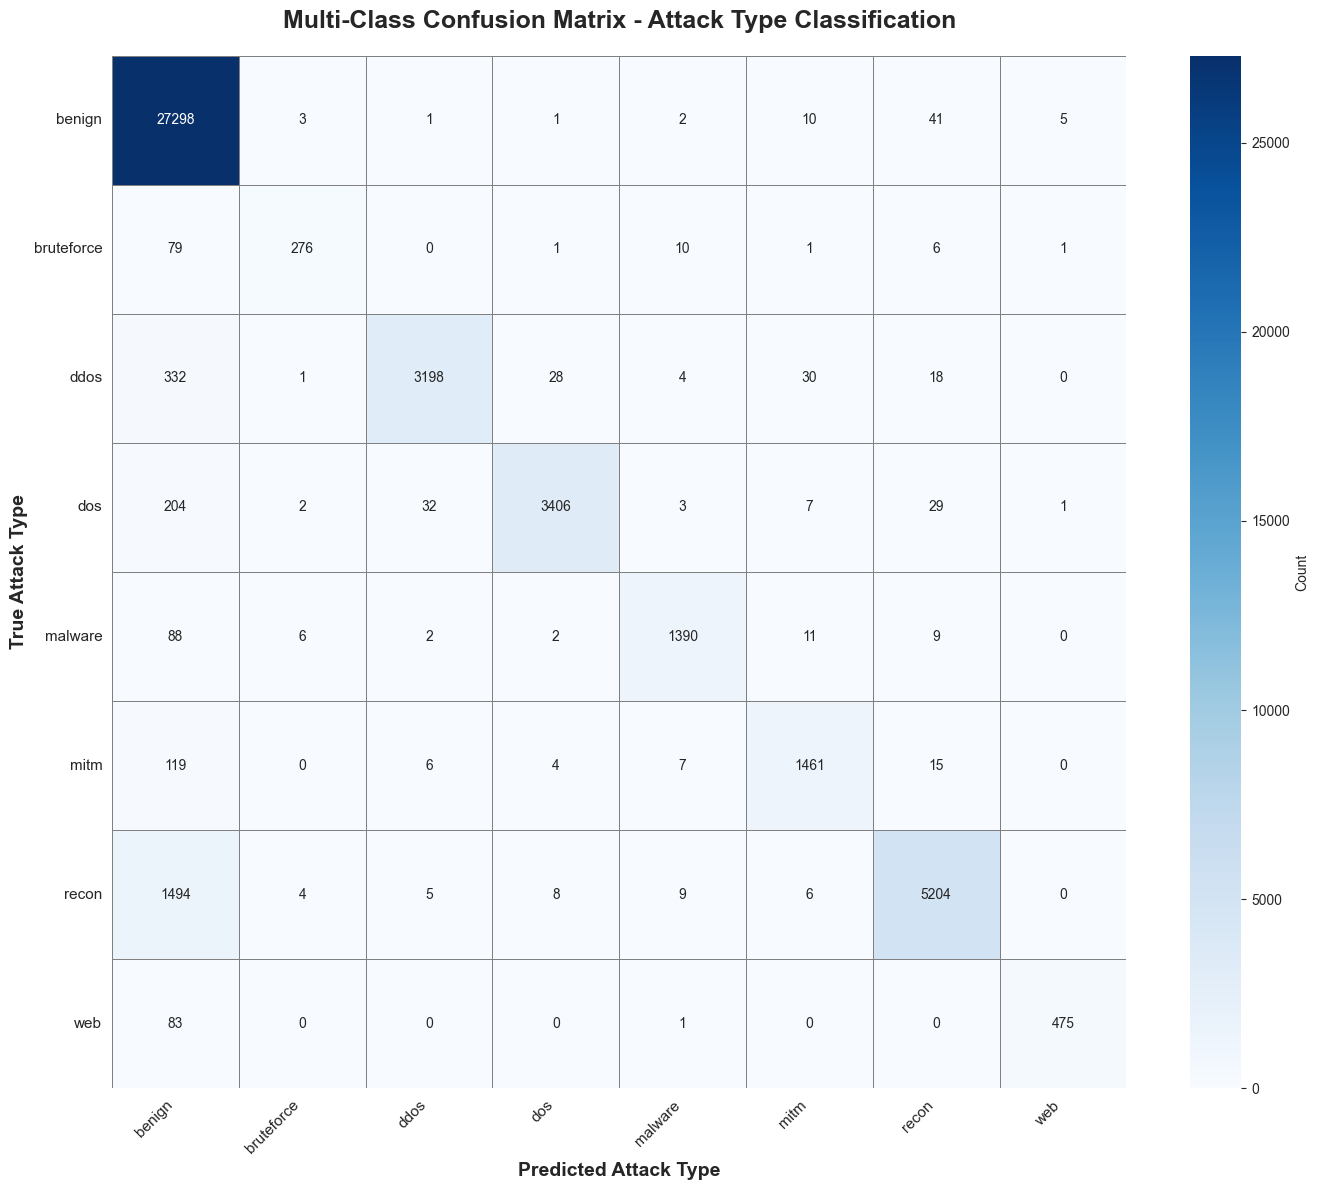

In [11]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, 
            yticklabels=le.classes_,
            cbar_kws={'label': 'Count'},
            linewidths=0.5,
            linecolor='gray')
plt.title('Multi-Class Confusion Matrix - Attack Type Classification', 
          fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Predicted Attack Type', fontsize=14, fontweight='bold')
plt.ylabel('True Attack Type', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(rotation=0, fontsize=11)
plt.tight_layout()
plt.show()

### 1.4 results breakdown

In [12]:
# ============================================
# ATTACK-BY-ATTACK BREAKDOWN
# ============================================
print("\n" + "="*60)
print("🔍 Detailed Breakdown by Attack Type:")
print("="*60)

for i, attack_type in enumerate(le.classes_):
    mask = y_test == i
    if sum(mask) > 0:
        correct = sum((y_test == i) & (y_pred == i))
        total = sum(mask)
        acc_class = correct / total
        
        # Emoji based on accuracy
        if acc_class >= 0.95:
            emoji = "🟢"
        elif acc_class >= 0.85:
            emoji = "🟡"
        else:
            emoji = "🔴"
            
        print(f"{emoji} {attack_type:15s}: {correct:5,}/{total:5,} correct ({acc_class*100:6.2f}%)")




🔍 Detailed Breakdown by Attack Type:
🟢 benign         : 27,298/27,361 correct ( 99.77%)
🔴 bruteforce     :   276/  374 correct ( 73.80%)
🟡 ddos           : 3,198/3,611 correct ( 88.56%)
🟡 dos            : 3,406/3,684 correct ( 92.45%)
🟡 malware        : 1,390/1,508 correct ( 92.18%)
🟡 mitm           : 1,461/1,612 correct ( 90.63%)
🔴 recon          : 5,204/6,730 correct ( 77.33%)
🔴 web            :   475/  559 correct ( 84.97%)


## Model 2 : Random Forest 

### 1.1 Training of model

In [13]:
rf_multi = RandomForestClassifier(
    n_estimators=500,
    max_depth=25,               # Prevents overfitting
    class_weight='balanced',    # Adjusts for class imbalance
    random_state=42,
    n_jobs=-1
)
rf_multi.fit(X_train_scaled, y_train) 
print("✅ Training complete!")

✅ Training complete!


### 1.2 Make predictions & overall performance

In [14]:
y_pred = rf_multi.predict(X_test_scaled)

# ============================================
# OVERALL ACCURACY
# ============================================
print("\n" + "="*80)
print("🎯 MULTI-CLASS CLASSIFICATION RESULTS")
print("="*80)

acc = accuracy_score(y_test, y_pred)
print(f"\n🎯 Overall Accuracy: {acc:.4f} ({acc*100:.2f}%)")

# ============================================
# DETAILED CLASSIFICATION REPORT (formatted)
# ============================================
report = classification_report(
    y_test, y_pred, 
    target_names=le.classes_, 
    digits=2
)
print("\nClassification Report:")
print(report)



🎯 MULTI-CLASS CLASSIFICATION RESULTS

🎯 Overall Accuracy: 0.9371 (93.71%)

Classification Report:
              precision    recall  f1-score   support

      benign       0.92      0.99      0.95     27361
  bruteforce       0.94      0.74      0.83       374
        ddos       0.98      0.88      0.93      3611
         dos       0.98      0.93      0.95      3684
     malware       0.95      0.92      0.94      1508
        mitm       0.95      0.91      0.93      1612
       recon       0.96      0.78      0.86      6730
         web       0.99      0.85      0.91       559

    accuracy                           0.94     45439
   macro avg       0.96      0.87      0.91     45439
weighted avg       0.94      0.94      0.94     45439



### 1.3 confusion matrix

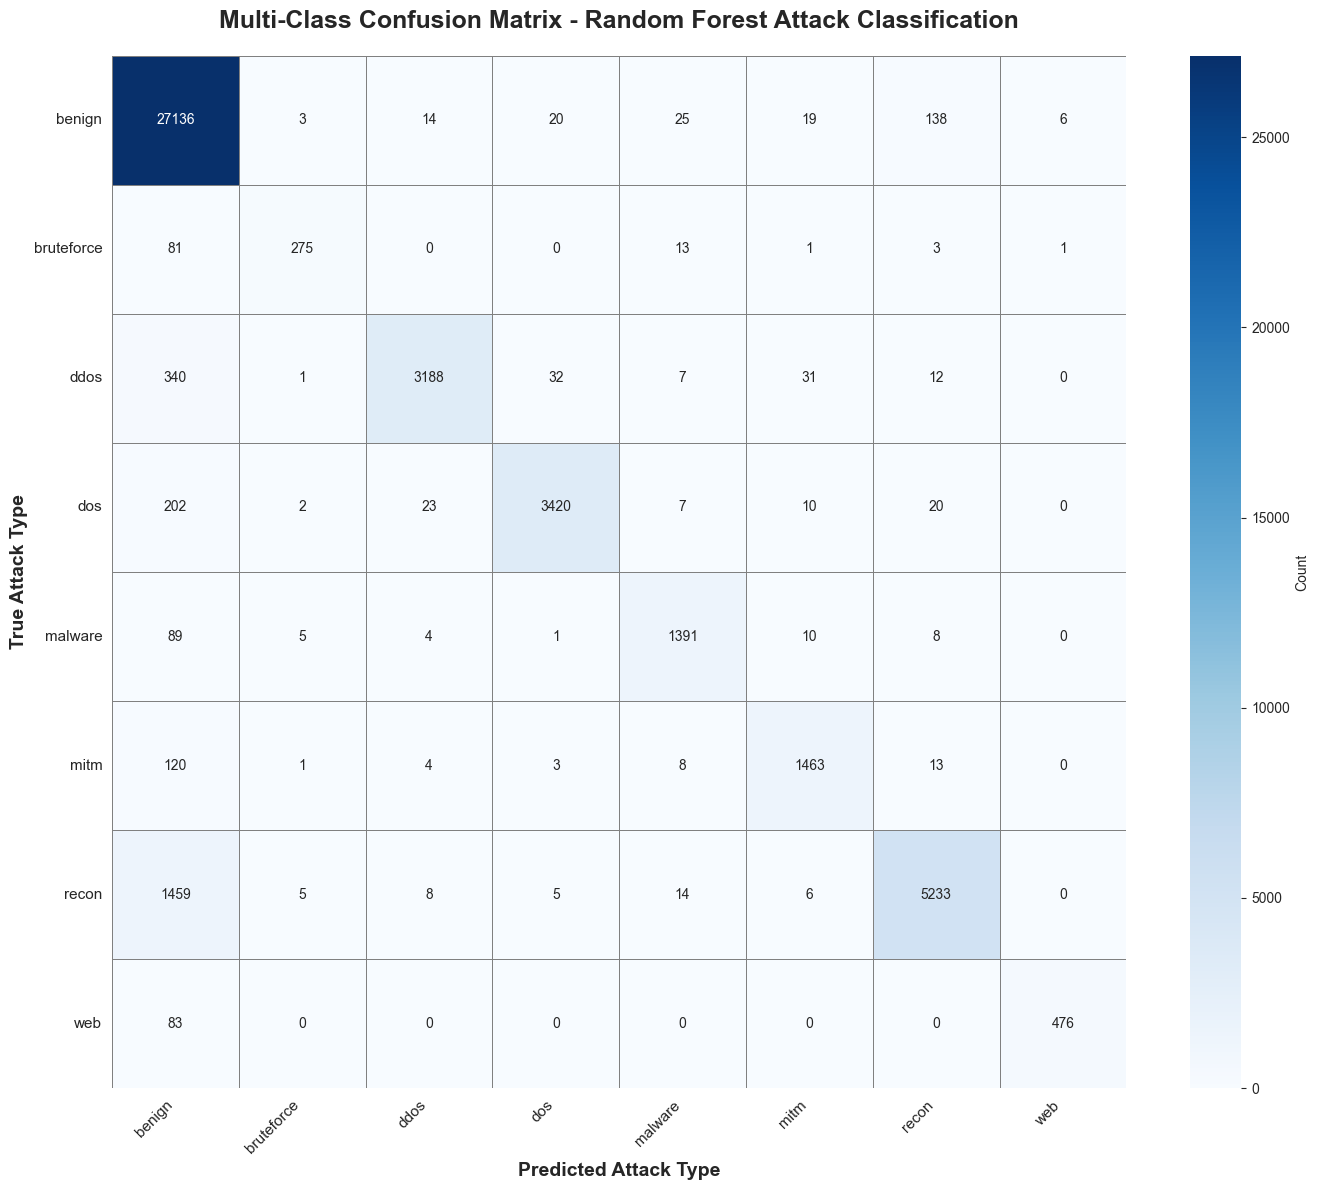

In [16]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            cbar_kws={'label': 'Count'},
            linewidths=0.5,
            linecolor='gray')
plt.title('Multi-Class Confusion Matrix - Random Forest Attack Classification',
          fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Predicted Attack Type', fontsize=14, fontweight='bold')
plt.ylabel('True Attack Type', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(rotation=0, fontsize=11)
plt.tight_layout()
plt.show()

### 1.4 Results Breakdown

In [85]:
print("\n" + "="*60)
print("🔍 Detailed Breakdown by Attack Type:")
print("="*60)

for i, attack_type in enumerate(le.classes_):
    mask = y_test == i
    if sum(mask) > 0:
        correct = sum((y_test == i) & (y_pred == i))
        total = sum(mask)
        acc_class = correct / total

        # Emoji based on accuracy
        if acc_class >= 0.95:
            emoji = "🟢"
        elif acc_class >= 0.85:
            emoji = "🟡"
        else:
            emoji = "🔴"

        print(f"{emoji} {attack_type:15s}: {correct:5,}/{total:5,} correct ({acc_class*100:6.2f}%)")


🔍 Detailed Breakdown by Attack Type:
🟢 benign         : 27,136/27,361 correct ( 99.18%)
🔴 bruteforce     :   275/  374 correct ( 73.53%)
🟡 ddos           : 3,188/3,611 correct ( 88.29%)
🟡 dos            : 3,420/3,684 correct ( 92.83%)
🟡 malware        : 1,391/1,508 correct ( 92.24%)
🟡 mitm           : 1,463/1,612 correct ( 90.76%)
🔴 recon          : 5,233/6,730 correct ( 77.76%)
🟡 web            :   476/  559 correct ( 85.15%)


# Model 3 : Light  GBM

### 1.1 Training of model 

In [86]:
    pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [17]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(
    n_estimators=300,
    max_depth=10,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

print("⏳ Training LightGBM...")
lgbm.fit(X_train_scaled, y_train)
print("✅ Training complete!")


⏳ Training LightGBM...
✅ Training complete!


### 1.2 Make predictions & Overall performances

In [18]:
y_pred_lgbm = lgbm.predict(X_test_scaled)

# Evaluation
acc = accuracy_score(y_test, y_pred_lgbm)
f1 = f1_score(y_test, y_pred_lgbm, average='weighted')

print(f"\n🎯 Test Set Performance:")
print(f"   Accuracy: {acc:.4f}")
print(f"   F1-Score: {f1:.4f}")

# Per-class breakdown
print("\n📋 Per-Class Performance:")
for i, attack_type in enumerate(le.classes_):
    mask = y_test == i
    if sum(mask) > 0:
        correct = sum((y_test == i) & (y_pred_lgbm == i))
        total = sum(mask)
        acc_class = correct / total
        emoji = "🟢" if acc_class >= 0.95 else "🟡" if acc_class >= 0.85 else "🔴"
        print(f"   {emoji} {attack_type:20s}: {correct:5,}/{total:5,} ({acc_class*100:5.1f}%)")


C:\Users\Microsoft\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🎯 Test Set Performance:
   Accuracy: 0.9406
   F1-Score: 0.9389

📋 Per-Class Performance:
   🟢 benign              : 27,301/27,361 ( 99.8%)
   🔴 bruteforce          :   276/  374 ( 73.8%)
   🟡 ddos                : 3,202/3,611 ( 88.7%)
   🟡 dos                 : 3,419/3,684 ( 92.8%)
   🟡 malware             : 1,391/1,508 ( 92.2%)
   🟡 mitm                : 1,462/1,612 ( 90.7%)
   🔴 recon               : 5,215/6,730 ( 77.5%)
   🔴 web                 :   475/  559 ( 85.0%)


### 1.3 Confusion Matrix 

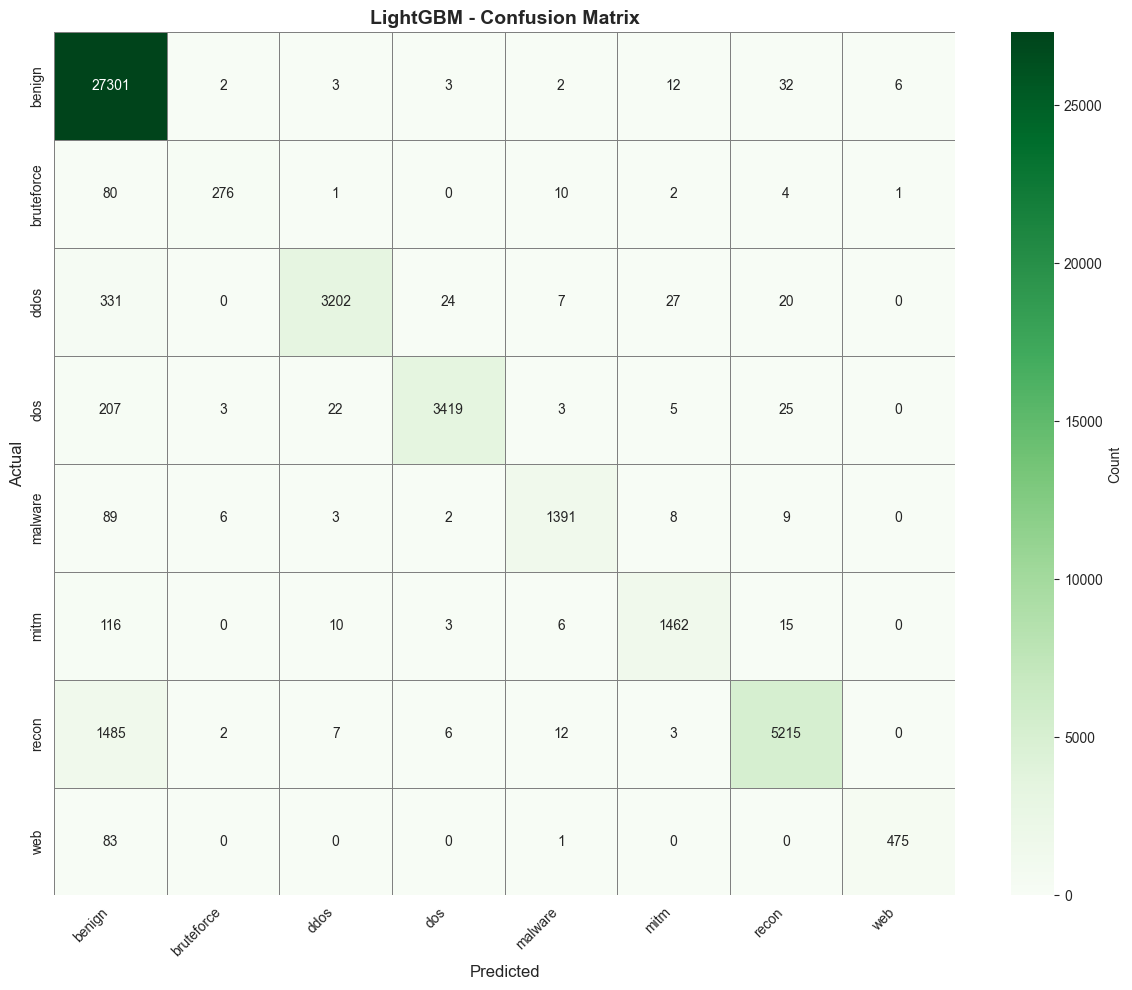

In [19]:
# Confusion Matrix
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)

plt.figure(figsize=(12, 10))
sns.heatmap(cm_lgbm, annot=True, fmt='d', cmap='Greens',
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            cbar_kws={'label': 'Count'},
            linewidths=0.5,
            linecolor='gray')
plt.title('LightGBM - Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()